### Importing required libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

### Data Exploration

In [ ]:
# Path to labels
labels_df = pd.read_csv('/content/drive/MyDrive/traffic_Data/labels.csv')
labels_df

,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)
5,5,Speed limit (60km/h)
6,6,Speed limit (70km/h)
7,7,speed limit (80km/h)
8,8,Dont Go straight or left
9,9,Dont Go straight or Right


Some column values are filled with 'unknown'; let's fix this to make the data more meaningful

In [ ]:
# Missing Names
missing_class_names = [
    'steep descent ahead', 'steep ascent ahead', 'Slow Down', 'T-intersection ahead',
    'Rough Road Ahead', 'Stop', 'Yield', 'No Entry'
]

# Assigning the correct class names to replace 'unknown' values accordingly.
for i, class_name in enumerate(missing_class_names):
  labels_df.loc[labels_df['Name'] == f'Unknown{i+1}','Name'] = class_name

# Printing updated DataFrame
print(labels_df[labels_df["Name"].isin(missing_class_names)])

    ClassId                  Name
40       40   steep descent ahead
41       41    steep ascent ahead
42       42             Slow Down
45       45  T-intersection ahead
49       49      Rough Road Ahead
52       52                  Stop
56       56                 Yield
57       57              No Entry


In [ ]:
# Path to Images
DATA_PATH = "/content/drive/MyDrive/traffic_Data/DATA"

# Define image dimensions
IMG_WIDTH, IMG_HEIGHT = 64, 64

In [ ]:
# Defining ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

### Training and Validation Generators

In [ ]:
# Training data generator
train_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_WIDTH,IMG_HEIGHT),
    class_mode='sparse',
    subset='training'
)

# Validation data generator
val_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_WIDTH,IMG_HEIGHT),
    class_mode='sparse',
    subset='validation'
)

Found 3359 images belonging to 58 classes.
Found 811 images belonging to 58 classes.


In [ ]:
# Mapping class indices to actual names
class_indices = train_generator.class_indices
class_map = {v: k for k, v in class_indices.items()}

### Visualizing Sample Images

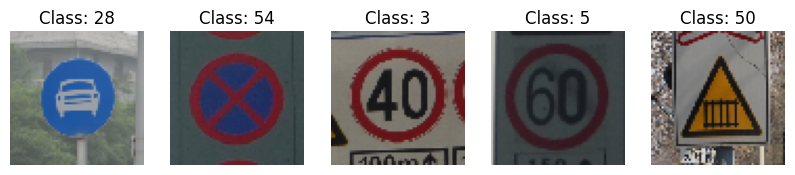

In [ ]:
# Get a batch of images and labels
images, labels = next(train_generator)

# Convert labels to integer type
labels = labels.astype(int)  # Ensure labels are integers

# Display first 5 images
plt.figure(figsize=(10, 5))
for i in range(5):

    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])

    # Get correct class name
    class_name = class_map[labels[i]]
    plt.title(f"Class: {class_name}")
    plt.axis("off")

plt.show()

### Model Building

In [ ]:
# Define CNN Model
model = Sequential([

    # Convolutional Layer 1
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2,2),

    # Convolutional layer 2
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Convolutional layer 3
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

     # Flattening
    Flatten(),

    # Dense Layer
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')

])

# Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 58)                  │           7,482 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 690,682 (2.63 MB)

 Trainable params: 690,682 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,validation_data=val_generator,epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 1747s 17s/step - accuracy: 0.1403 - loss: 3.6171 - val_accuracy: 0.4464 - val_loss: 2.2382
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step - accuracy: 0.4332 - loss: 2.2019 - val_accuracy: 0.6621 - val_loss: 1.1807
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.6390 - loss: 1.2892 - val_accuracy: 0.8002 - val_loss: 0.7156
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.7256 - loss: 0.9157 - val_accuracy: 0.8533 - val_loss: 0.5169
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 182ms/step - accuracy: 0.7904 - loss: 0.6870 - val_accuracy: 0.8841 - val_loss: 0.3926
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step - accuracy: 0.8306 - loss: 0.5707 - val_accuracy: 0.9199 - val_loss: 0.3032
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - accuracy: 0.8605 - loss: 0.4535 - val_accuracy: 0.9470 - val_loss: 0.2193
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.8766 - loss: 0

### Plotting Training and Validation Accuracy Over Epochs

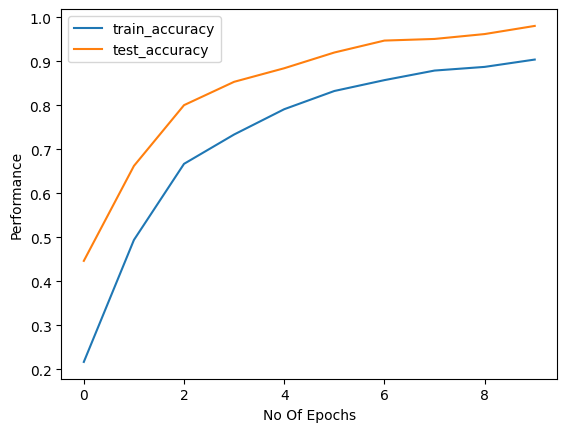

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('No Of Epochs')
plt.ylabel('Performance')
plt.legend(['train_accuracy','test_accuracy'])
plt.show()

In [ ]:
# Model Evaluation
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.9812 - loss: 0.1241
Validation Accuracy: 98.03%
Validation Loss: 0.1214


### Conclusion
The CNN model was trained to classify traffic signs using labeled image data. Missing class names were updated, and images were preprocessed for better learning. The model showed good accuracy in both training and validation, indicating effective learning. Further improvements can be made with more data, augmentation, and tuning.







